<a href="https://colab.research.google.com/github/lorenzopasquetto/test1/blob/main/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
from sklearn.preprocessing import MinMaxScaler

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dataset = np.load("training_dataset/training_data.npy")
print(dataset.shape)


categories = np.load("training_dataset/categories.npy")
print(categories.shape)


valid_p = np.load("training_dataset/valid_periods.npy")
print(valid_p.shape)

(48000, 2776)
(48000,)
(48000, 2)


In [ ]:
test_set = dataset[-100:,:]
dataset = dataset[:-100,:]
valid_p = valid_p[:-100,:]

In [ ]:
print(dataset.shape, valid_p.shape)

(47900, 2776) (47900, 2)


In [ ]:
valid_p.shape

(47900, 2)

In [ ]:


dataset.shape
sum_b = 0
sum_f = 0
invalid_line = [0]

for ind, i in enumerate(valid_p):
  if(i[0]>2680):
    invalid_line = np.vstack((invalid_line, ind))
    if(ind<15):
          print(ind)


  sum_b = i[0] + sum_b
  sum_f = i[1] + sum_f


val_b = sum_b/(ind+1)
val_f = sum_f/(ind+1)
invalid_line = invalid_line[1:,0]

3
4
6
7


In [ ]:
# Remove the rows based on the indices
matrix_without_rows = np.delete(dataset, invalid_line, axis=0)


In [ ]:
matrix_without_rows.shape


(32793, 2776)

In [ ]:
###########################################################################################
#X = dataset[:,1276:]
#print(X.shape[1]%stride)
dom_adj = 250 - val_f + round(val_b)
print(dom_adj, val_f, round(val_b))
X = matrix_without_rows[:, round(val_b)-52:round(val_f)]
stride = 10
print("Rest", X.shape[1]%stride)

df = X
count = True


X = df[:,0:218]
it = 1
b = 10
f = 228
while(count):

  temp = df[:, b : f ]
  if(temp.shape[1]!=218):
    print("Stop at iteration: ", it)
    break
  #print(temp.shape)
  print(b , f)
  X = np.vstack((X, temp))
  it = it +1
  b = b + stride
  f = f + stride
  #stride = stride + 10
  #count = df.shape[1]-stride-10 > 0



###########################################################################################

52.0 2776.0 2578
Rest 0
10 228
20 238
30 248
Stop at iteration:  4


In [ ]:
print(X.shape)
train_new = X.astype(np.float32)

(131172, 218)


In [ ]:


def clean_data(X_c):
  # Remove time series with only null components
  filtered_time_series_indices = [i for i, ts in enumerate(X_c) if np.sum(np.abs(ts)) > 0]
  filtered_time_series = np.array([X_c[i] for i in filtered_time_series_indices])
  #time_series = filtered_time_series
  #mean_values = np.mean(time_series, axis=1)
  #std_values = np.std(time_series, axis=1)


  #filtered_time_series_indices = [i for i, (ts, mean, std) in enumerate(zip(time_series, mean_values, std_values)) if np.max(np.abs(ts - mean)) < threshold * std]
  #filtered_time_series = np.array([time_series[i] for i in filtered_time_series_indices])
  return filtered_time_series


In [ ]:
train_set = train_new
test_set = test_set[:,-218:]

In [ ]:
train_set.shape

(131172, 218)

In [ ]:

y_size = 18

X_train = train_set[:,:-y_size] # all the sequence minus last y_size
y_train = train_set[:,-y_size:] # last y_size
print(X_train.shape, y_train.shape)

(131172, 200) (131172, 18)


In [ ]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
input_shape_lstm = np.array([X_train.shape[1],1])
print(input_shape_lstm)
print(output_shape)

[200   1]
18


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):


    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = input_layer

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)


    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    #output_layer = tfkl.Maxpooling()(output_layer)
    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
from tensorflow import keras
#from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfk.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfk.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfk.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfk.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tfk.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    x = tfk.layers.Dropout(dropout)(x)
    x = tfk.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    output_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfk.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfk.layers.Dense(dim, activation="relu")(x)
        x = tfk.layers.Dropout(mlp_dropout)(x)


    # Adjust the output layer for the desired shape (9 in this case)
    output = tfk.layers.Dense(output_shape, activation="linear")(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs= inputs, outputs=output, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


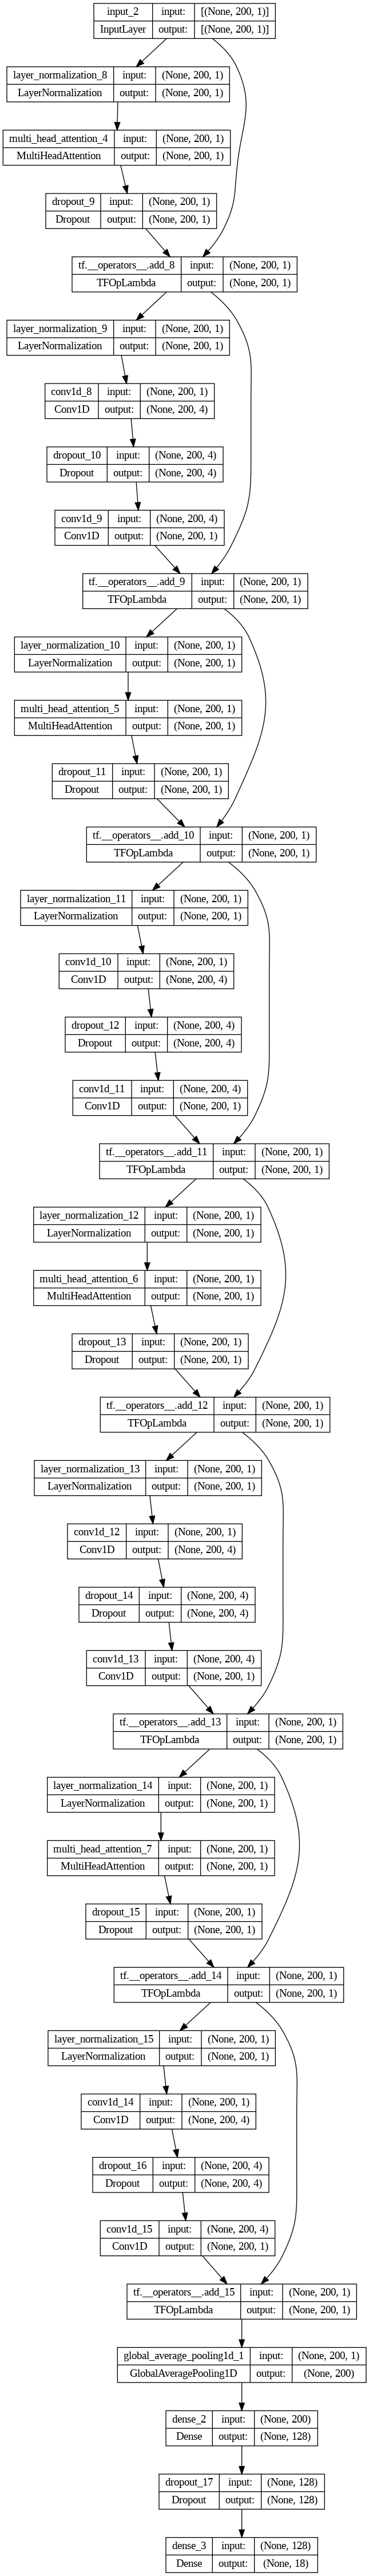

In [ ]:
model2 = build_model(
    input_shape_lstm,
    output_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
#model2.summary()
tfk.utils.plot_model(model2, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm1 (Bidir  (None, 200, 128)          33792     
 ectional)                                                       
                                                                 
 conv1 (Conv1D)              (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

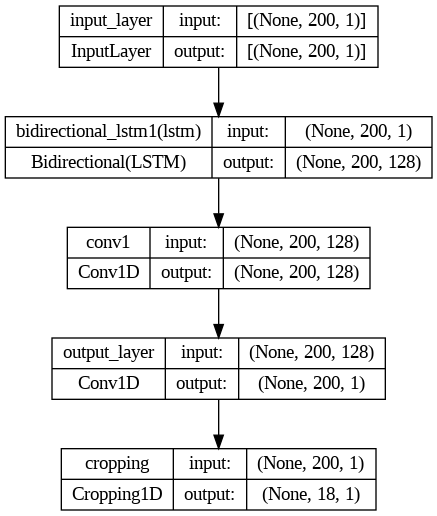

In [ ]:

model = build_CONV_LSTM_model(input_shape_lstm, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 128
epochs = 50
print(X_train.shape)
print(y_train.shape)
#print(categories_train.shape)


(131172, 200)
(131172, 18)


In [ ]:
history1 = model.fit(
    #x = (X_train,categories_train),
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
923/923 [==============================] - 21s 19ms/step - loss: 0.0685 - val_loss: 0.0695 - lr: 0.0010
Epoch 2/50
923/923 [==============================] - 16s 18ms/step - loss: 0.0279 - val_loss: 0.0220 - lr: 0.0010
Epoch 3/50
923/923 [==============================] - 16s 18ms/step - loss: 0.0201 - val_loss: 0.0221 - lr: 0.0010
Epoch 4/50
923/923 [==============================] - 16s 18ms/step - loss: 0.0197 - val_loss: 0.0204 - lr: 0.0010
Epoch 5/50
923/923 [==============================] - 16s 17ms/step - loss: 0.0194 - val_loss: 0.0202 - lr: 0.0010
Epoch 6/50
923/923 [==============================] - 16s 17ms/step - loss: 0.0193 - val_loss: 0.0200 - lr: 0.0010
Epoch 7/50
923/923 [==============================] - 16s 17ms/step - loss: 0.0190 - val_loss: 0.0202 - lr: 0.0010
Epoch 8/50
923/923 [==============================] - 16s 17ms/step - loss: 0.0188 - val_loss: 0.0196 - lr: 0.0010
Epoch 9/50
923/923 [==============================] - 16s 17ms/step - loss: 0.01

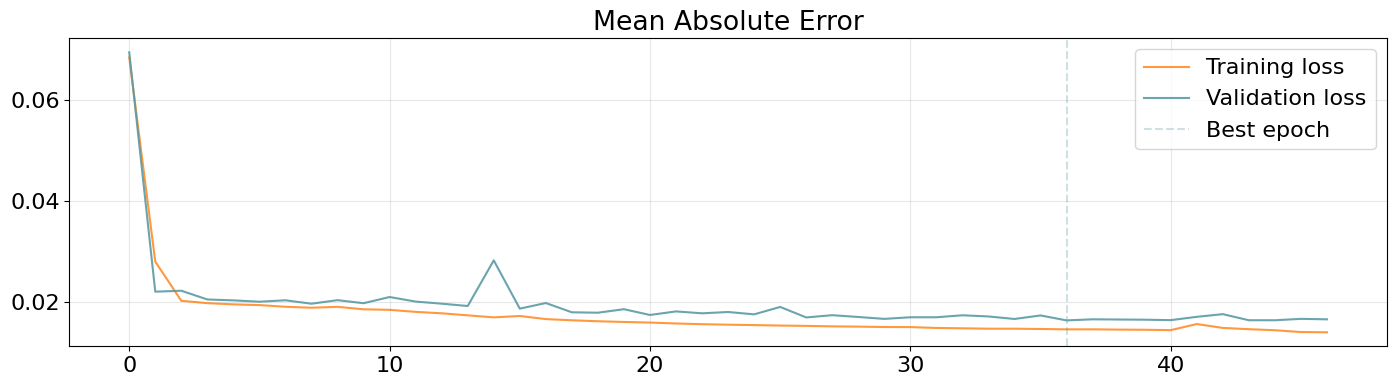

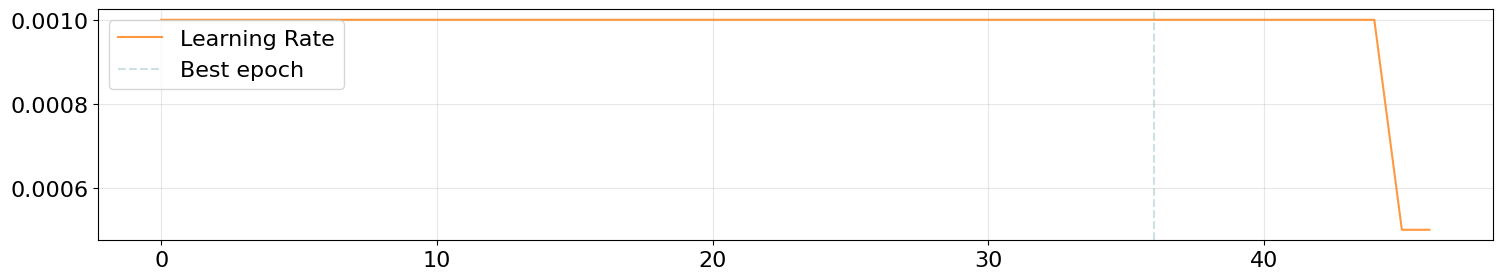

In [ ]:
history = history1
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:

X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0) # CONV LSTM model

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Absolute Error: {mean_absolute_error}")

Last model Mean Squared Error: 0.01626843586564064
Last model Mean Absolute Error: 0.08962758630514145


In [ ]:
history2 = model2.fit(
    #x = (X_train,categories_train),
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
923/923 [==============================] - 81s 78ms/step - loss: 0.0365 - val_loss: 0.0195 - lr: 0.0010
Epoch 2/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0216 - val_loss: 0.0188 - lr: 0.0010
Epoch 3/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0191 - val_loss: 0.0172 - lr: 0.0010
Epoch 4/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0179 - val_loss: 0.0169 - lr: 0.0010
Epoch 5/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0172 - val_loss: 0.0163 - lr: 0.0010
Epoch 6/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0168 - val_loss: 0.0168 - lr: 0.0010
Epoch 7/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0165 - val_loss: 0.0174 - lr: 0.0010
Epoch 8/50
923/923 [==============================] - 71s 77ms/step - loss: 0.0164 - val_loss: 0.0165 - lr: 0.0010
Epoch 9/50
923/923 [==============================] - 71s 77ms/step - loss: 0.01

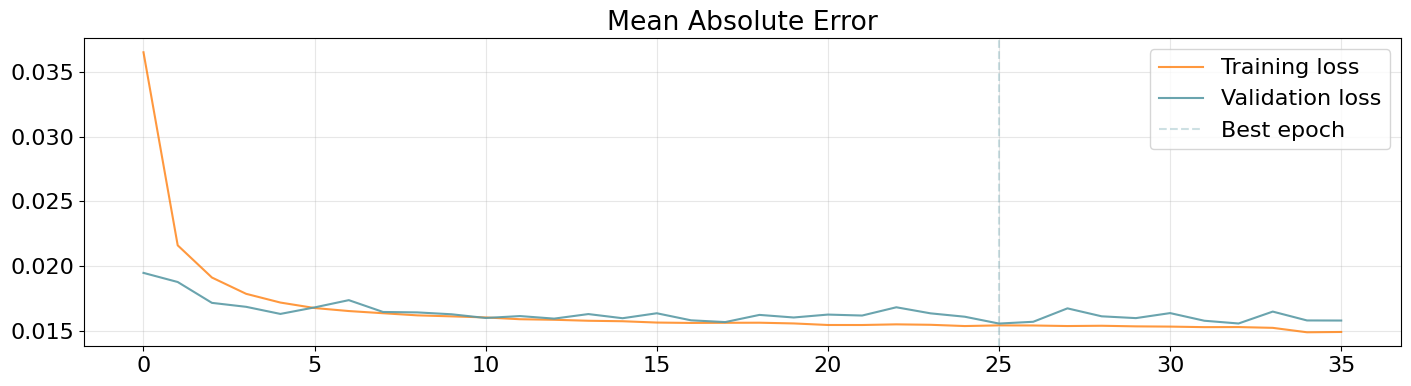

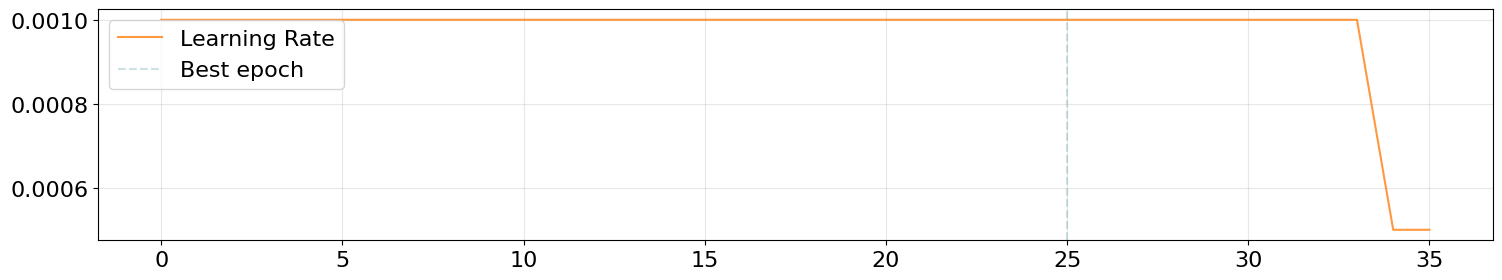

In [ ]:

history = history2

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size

# Predict the test set using the model
predictions = model2.predict(X_test, verbose=0)  # Transformers model

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Absolute Error: {mean_absolute_error}")


Last model Mean Squared Error: 0.014143651351332664
Last model Mean Absolute Error: 0.08436629921197891


In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size

# Predict the test set using the model
predictions = model2.predict(X_test, verbose=0)  # Transformers model

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Absolute Error: {mean_absolute_error}")

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0) # CONV LSTM model

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Last model Mean Absolute Error: {mean_absolute_error}")


Last model Mean Squared Error: 0.015006283298134804
Last model Mean Absolute Error: 0.08713752031326294
Last model Mean Squared Error: 0.016349291428923607
Last model Mean Absolute Error: 0.0935848131775856


In [ ]:
model.save('Trained/final_02_ng')

In [ ]:

output_model1 = model1.layers[-1].output
output_model2 = model2.layers[-1].output
#output_model3 = model3.layers[-1].output
#output_model4 = model4.layers[-1].output
#output_model5= model5.layers[-1].output

# Calcola la media delle uscite
average_outputs = tfkl.Average()([output_model1[0], output_model2[0]])

ensemble_model = tfk.Model(inputs=[model1.input, model2.input], outputs=average_outputs)

#ensemble_model = tfk.Model(inputs=[model1.input, model2.input, model3.input], outputs=ensemble_output)
# Compile the ensemble model (you may need to adjust the optimizer, loss, and metrics based on your problem)
#ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())


In [ ]:


## This ONE
from tensorflow.keras.models import load_model

#model = load_model("Trained/final_02_ng")

output_model1 = model.output
output_model2 = model2.output
#output_model3 = model3.output
#output_model4 = model4.output
#output_model5 = model5.output


#input_layer = tfk.Input(shape = (96,96,3))
# Concatenate the outputs along the last axis (axis=-1)
#merged_outputs = tfkl.Concatenate(axis=-1)([output_model1, output_model2])
# Add an output layer for binary classification
#ensemble_output = Dense(2, activation='sigmoid')(merged_outputs)
# Ottieni l'uscita degli ultimi layer dei tre modelli


output_model1 = model.layers[-1].output
output_model2 = model2.layers[-1].output
#output_model3 = model3.layers[-1].output
#output_model4 = model4.layers[-1].output
#output_model5= model5.layers[-1].output

output_model1 = tf.reshape(output_model1, shape=(-1, 18))



# Calcola la media delle uscite
average_outputs = tfkl.Average()([output_model1, output_model2])
ensemble_model = tfk.Model(inputs=[model.input, model2.input], outputs=average_outputs)

#ensemble_model = tfk.Model(inputs=[model1.input, model2.input, model3.input], outputs=ensemble_output)
# Compile the ensemble model (you may need to adjust the optimizer, loss, and metrics based on your problem)
#ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ensemble_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())


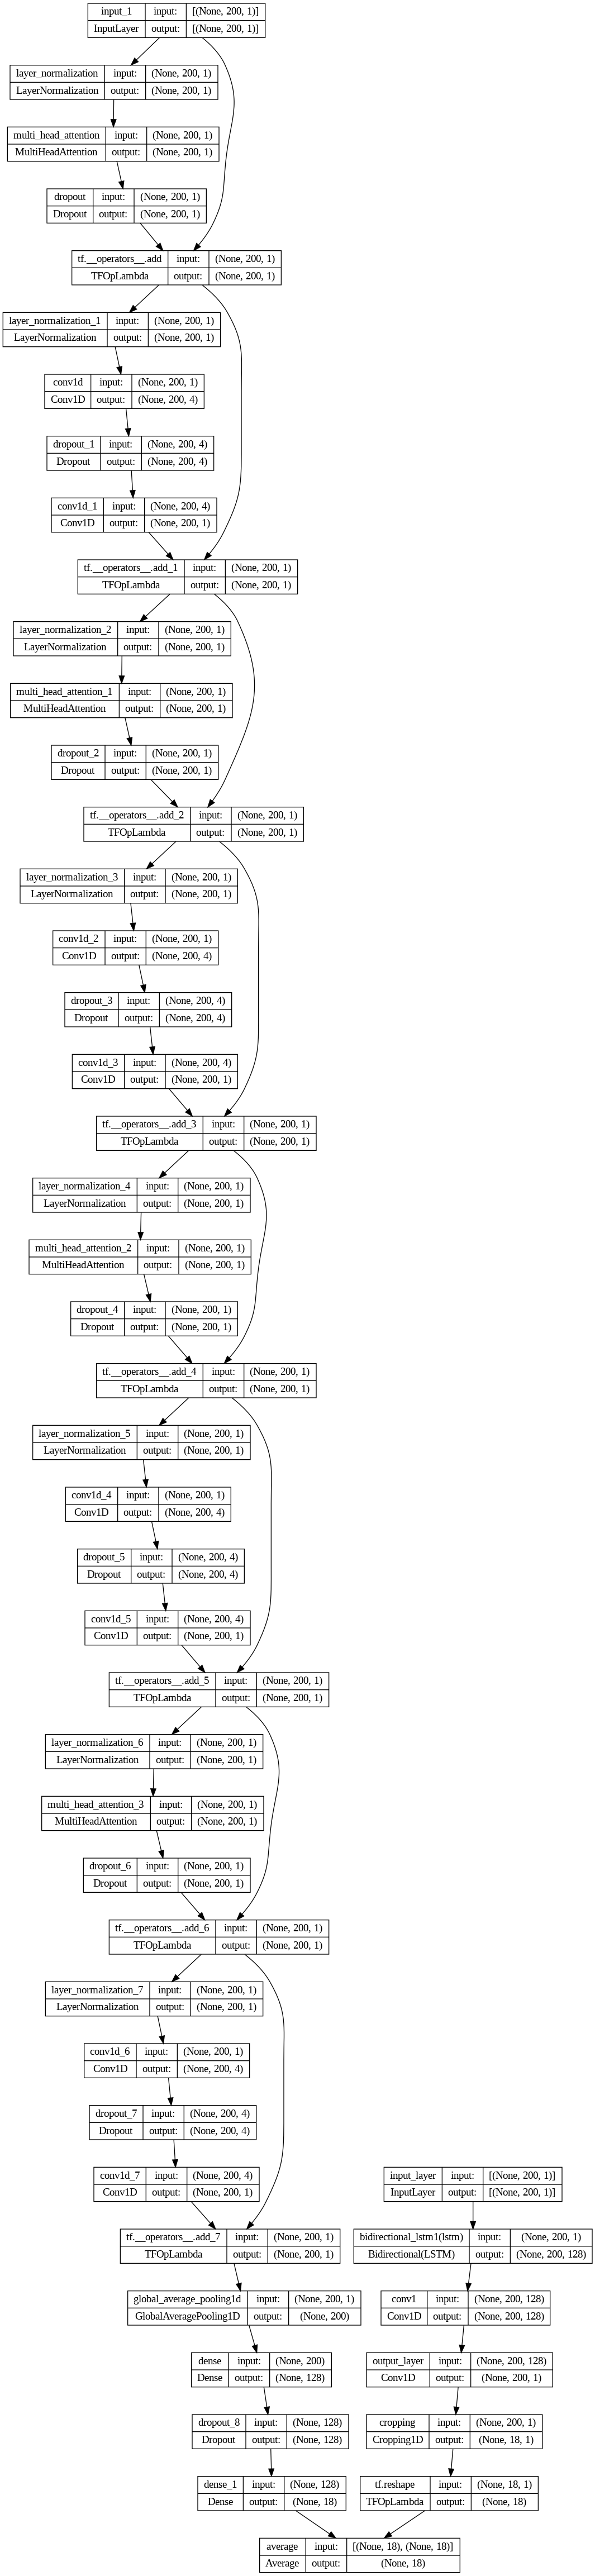

In [ ]:
tfk.utils.plot_model(ensemble_model, expand_nested=True, show_shapes=True)

In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size
from tensorflow.keras.models import load_model

#model1 = load_model("Trained/second_model")
#model2 = load_model("Trained/second_model_4")


# Predict the test set using the model
predictions = ensemble_model.predict([X_test, X_test], verbose=0)
#predictions2 = model1.predict(X_test, verbose=0)

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Absolute Error: {mean_absolute_error}")


Ensemble Model Mean Squared Error: 0.014753520488739014
Ensemble Model Mean Absolute Error: 0.08785198628902435


In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size
from tensorflow.keras.models import load_model

model_ens = load_model("Trained/final_01_ensemble")
#model2 = load_model("Trained/second_model_4")


# Predict the test set using the model
predictions = ensemble_model.predict([X_test, X_test], verbose=0)
#predictions2 = model1.predict(X_test, verbose=0)

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Absolute Error: {mean_absolute_error}")




# Predict the test set using the model
predictions = model_ens.predict([X_test, X_test], verbose=0)
#predictions2 = model1.predict(X_test, verbose=0)

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Absolute Error: {mean_absolute_error}")


Ensemble Model Mean Squared Error: 0.014748523943126202
Ensemble Model Mean Absolute Error: 0.08541370928287506
Ensemble Model Mean Squared Error: 0.013182736933231354
Ensemble Model Mean Absolute Error: 0.08016312122344971


In [ ]:
ensemble_model.save('Trained/final_01_ensemble')

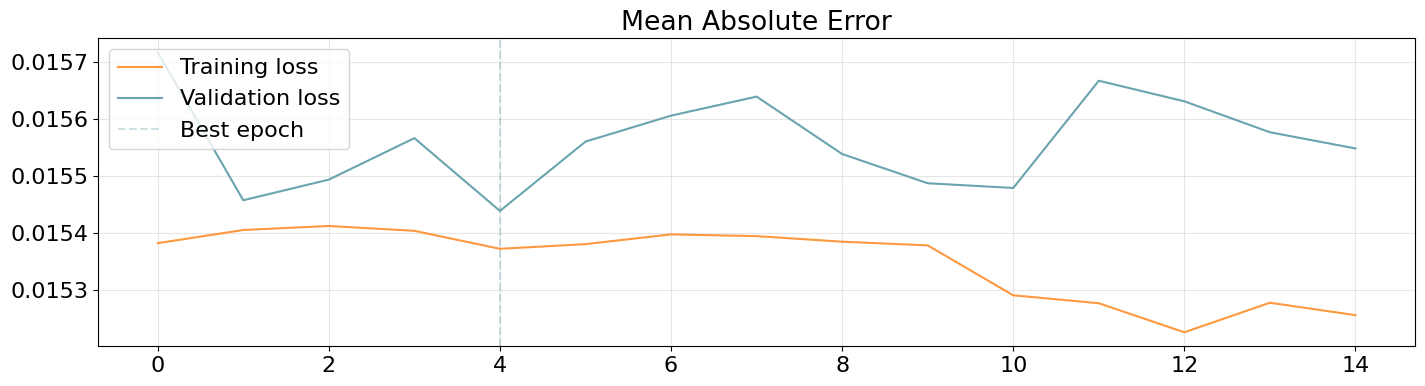

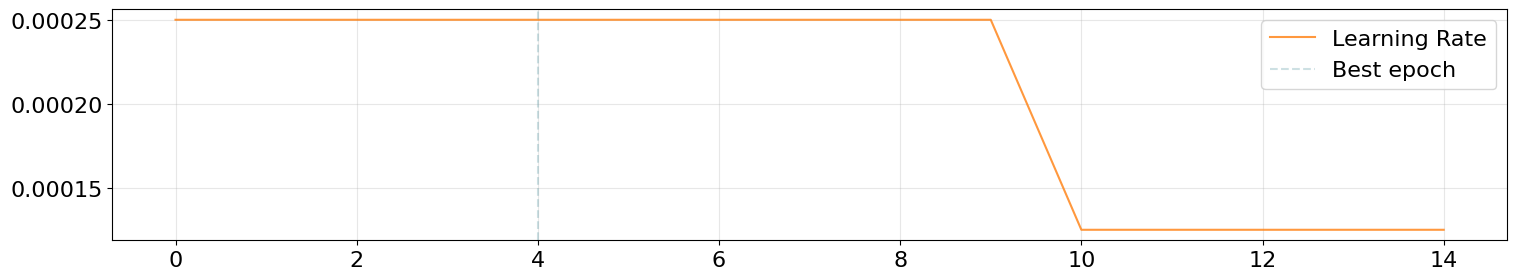

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
################################################################################################################################################################

In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size
from tensorflow.keras.models import load_model


model_ens = load_model("Trained/final_01_ensemble")





In [ ]:
X_test = test_set[:,:-y_size] # all the sequence minus last y_size
y_test = test_set[:,-y_size:] # last y_size
from tensorflow.keras.models import load_model

ensemble_model = load_model("Trained/final_01_ensemble")
#model2 = load_model("Trained/second_model_4")


# Predict the test set using the model
predictions = ensemble_model.predict([X_test, X_test], verbose=0)
#predictions2 = model1.predict(X_test, verbose=0)

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Ensemble Model Mean Absolute Error: {mean_absolute_error}")




Ensemble Model Mean Squared Error: 0.013182736933231354
Ensemble Model Mean Absolute Error: 0.08016312122344971
